# TOF Sensor Data Analysis - Cycling Tests

## Objective

The objective of this notebook is to analyze the effectiveness of WaveShare's Time of Flight (TOF) sensor at measuring distance, and draw conclusions from the data measured.

## Overview

I conducted 3 tiers of testing and data collection:

1. **Basic Tests**: The goal of this level of testing was to determine the accuracy of the TOF sensor in a controlled environment.
2. **Simple Outdoors Tests**: After setting up the sensor on a bicycle, the next level of testing involved riding past stationary objects and determining the accuracy of the data collected, and how effective the sensor was as a binary object detector.
3. **Cycling Tests**: The final level of testing involved using the sensor to measure the distances of cars overtaking the cyclist. The goal of this project is to ultimately collect data on this subject.

In [2]:
import datetime
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from data_loader import get_data_from_txt, get_data_from_folder

## Cycling Tests

- Now, it was time to test the sensor on the road in real-world conditions.
- I mounted the sensor with its casing on a bike and rode it down different roads in Singapore.

### Setup

- Along with the sensor, a GoPro was attached to the bike which could be used to visually check when cars overtook the cyclist. With this, I could cross reference the data measured by the sensor and determine it's validity.
- I used the same functions for the simple outdoors tests to clean and extract the data and below, I define a few more helper functions.

In [3]:
def clean_data(data: list[int]) -> list[int]:
    """
    Attempt to remove spurious data by removing standalone points.

    Args:
        data (list[int]): List of distances.

    Returns:
        list[int]: Cleaned list of distances.
    """
    cleaned_data = data.copy()

    for i, distance in enumerate(cleaned_data):
        if distance == -1:
            continue

        neighbors = get_neighbors(cleaned_data, i)
        if len(neighbors) <= 1:
            cleaned_data[i] = -1

    return cleaned_data


def get_neighbors(data: list[int], index: int, window=2) -> list[int]:
    """
    Get all non -1 neighbors of the point at index within left and right window.

    Args:
        data (list[int]): List of distances.
        index (int): Index of current point.
        window (int): Window to look for neighbors.

    Returns:
        list[int]: Non -1 neighbors.
    """
    neighbors = []

    for i in range(max(0, index - window), min(len(data), index + window + 1)):
        if data[i] != -1:
            neighbors.append(data[i])

    return neighbors

In [4]:
def scatter_time_vs_distance(ax: mpl.axes.Axes, timing: list[datetime.datetime], distances: list[int], title="") -> None:
    """
    Plot a scatter plot of time against distance.

    Args:
        ax (mpl.axes.Axes): Matplotlib axes object.
        timing (list[datetime.datetime]): List of timings for each distance measured.
        distances (list[int]): List of distances measured by the sensor.
        title (str, optional): Title of the graph. Defaults to "".
    """
    timing, distances = remove_null_points(timing, distances)
    ax.scatter(timing, distances, s=12)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Distance (mm)")


def remove_null_points(x: list, y: list, null_value=-1) -> tuple[list, list]:
    """
    Given the x and y values for a graph, remove all points where y = null_value.
    This is to prevent a whole row of -1 distances being plotted at the bottom of the graph.

    Args:
        x (list): x values to plot.
        y (list): y values to plot
        null_value (int, optional): The null value to be removed. Defaults to -1.

    Returns:
        tuple[list, list]: _description_
    """
    n = len(x)
    new_x = []
    new_y = []

    for i in range(n):
        if y[i] == null_value:
            continue
        new_x.append(x[i])
        new_y.append(y[i])

    return new_x, new_y


def annotate_graph(ax: mpl.axes.Axes, timing: str, distance: int, description="") -> None:
    timing = datetime.datetime.strptime(timing, "%H:%M:%S")
    ax.annotate(description,
                xy=(timing, distance),
                xycoords="data",
                xytext=(timing, distance - 500),
                arrowprops=dict(arrowstyle="->"))

### Lakeside Road

- The recorded video can be found [here](./cycling_videos/Lakeside_Rd.mp4).
- I graph both the raw and cleaned data in two scatter plot graphs.
- From the first graph, we see how many spurious points there are and how it might be difficult to reliably determine with the sensor if a vehicle really passed the bike.
- In the second graph, I cleaned the data using the above algorithm and annotated it based on the GoPro's recording. I included the vehicles the sensor passed and a rough estimate of the distance from the bike.
- We see that there are 3 instances where it is obvious that a vehicle passed the bicycle. From the video recording, these 3 instances occured when the vehicles passed very closely to the bike.
- Other than these 3 points, the sensor did not pick up on vehciles that passed further from the bike, and even missed out on a bike which was too small to be sensed..

In [5]:
LAKESIDE_RD_PATH = pathlib.Path("./data/cycling_tests/lakeside_drive.txt")

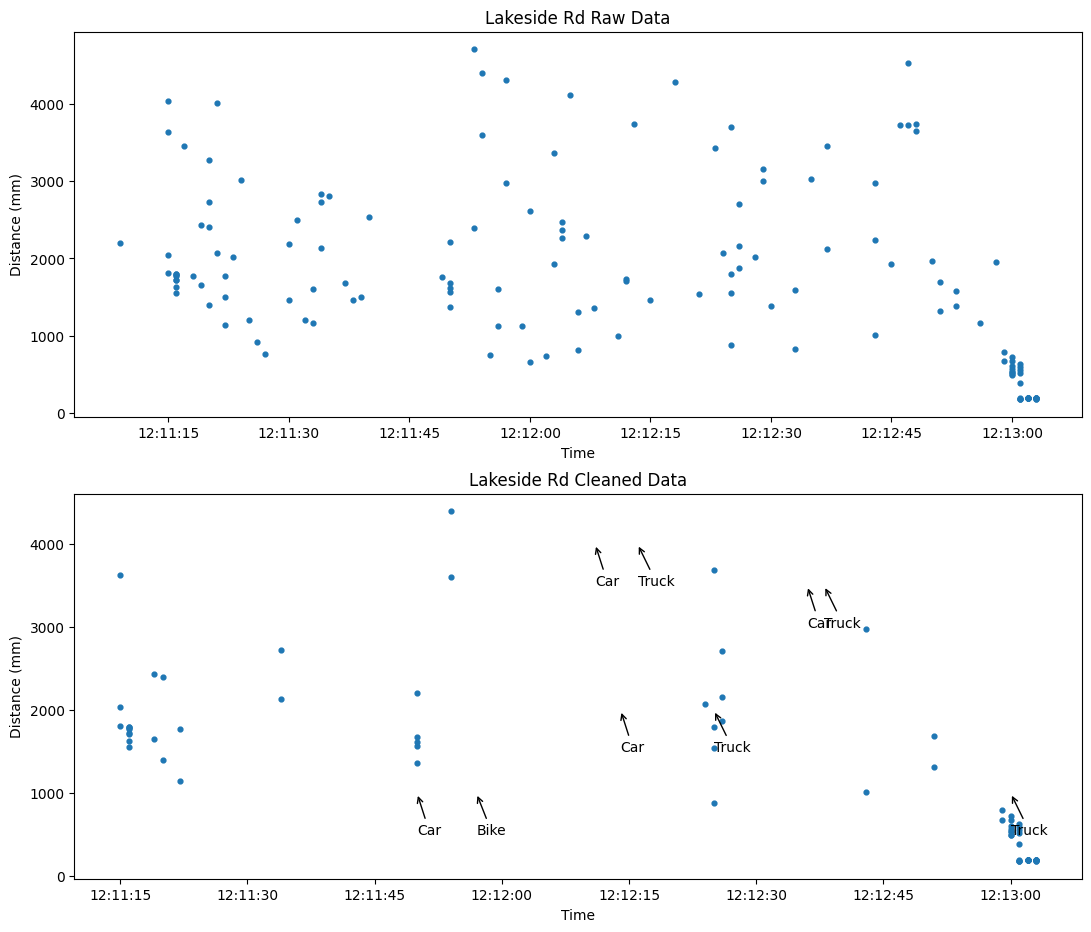

In [6]:
timing, distances, signal_strengths = get_data_from_txt(LAKESIDE_RD_PATH)
cleaned_distances = clean_data(distances)

fig, axes = plt.subplots(2, figsize=(13, 11))
scatter_time_vs_distance(axes[0], timing, distances, title="Lakeside Rd Raw Data")
scatter_time_vs_distance(axes[1], timing, cleaned_distances, title="Lakeside Rd Cleaned Data")

annotate_graph(axes[1], "12:11:50", 1000, "Car")
annotate_graph(axes[1], "12:11:57", 1000, "Bike")
annotate_graph(axes[1], "12:12:11", 4000, "Car")
annotate_graph(axes[1], "12:12:14", 2000, "Car")
annotate_graph(axes[1], "12:12:16", 4000, "Truck")
annotate_graph(axes[1], "12:12:25", 2000, "Truck")
annotate_graph(axes[1], "12:12:36", 3500, "Car")
annotate_graph(axes[1], "12:12:38", 3500, "Truck")
annotate_graph(axes[1], "12:13:00", 1000, "Truck")

plt.show()